In [12]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

# Load the full scan

In [13]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [49]:
quantile_band = 0.5

# channel_list = [channel_LaserDiode]
channel_list = [channel_diode_1, channel_diode_2, channel_Izero117, channel_Izero122]


################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Position_mm = scan.readbacks

Signal_APD1 = []
Signal_APD2 = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):

    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

    results, _ = load_data_compact(channel_list, step)

    Izero117_shot = results[channel_Izero117]      
    Izero122_shot = results[channel_Izero122]
    signalAPD1_shot =  results[channel_diode_1]
    signalAPD2_shot =  results[channel_diode_2]

    signalAPD1_norm_shot = signalAPD1_shot / Izero122_shot              #Normalization with PBPS117
    signalAPD2_norm_shot = signalAPD2_shot / Izero122_shot              #Normalization with PBPS117

    #signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122

    df_signalAPD1 = pd.DataFrame(signalAPD1_norm_shot)
    Signal_APD1.append(np.nanquantile(df_signalAPD1, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    df_signalAPD2 = pd.DataFrame(signalAPD2_norm_shot)
    Signal_APD2.append(np.nanquantile(df_signalAPD2, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    #df_Izero117 = pd.DataFrame(Izero117_shot)
    #Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    #df_Izero122 = pd.DataFrame(Izero122_shot)
    #Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Position_mm = Position_mm[:np.shape(Signal_APD1)[0]]
Signal_APD1 = np.asarray(Signal_APD1)
Signal_APD2 = np.asarray(Signal_APD2)
# Izero117 = np.asarray(Izero117)
# Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 31 of 31: Processing run_014452

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 499 / 503 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 503 / 503 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 503 -> 1% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.25,0.75


<IPython.core.display.Javascript object>


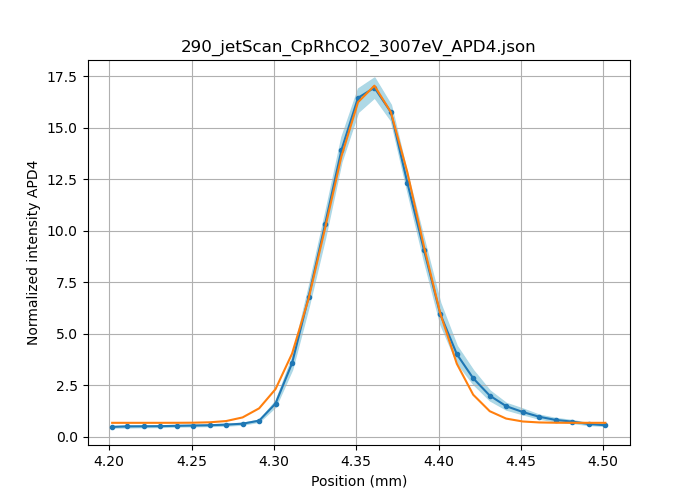

Center position = 4.360 mm
Width = 64.603 um


In [52]:
Int_APD1 = Signal_APD1[:,0]
err_low_APD1 = Signal_APD1[:,1]
err_high_APD1 = Signal_APD1[:,2]

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Position_mm, Int_APD1)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Position_mm, Int_APD1)                  # calculate the fit
Int_fit = fit.eval(Position_mm)            # evaluate the curve for plotting

center = fit.popt[0]
width = fit.popt[2]*2.355

plt.figure(figsize=(7,5))
plt.title(fc.selected_filename)
plt.plot(Position_mm, Int_APD1, label='direction X, APD1, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low_APD1, err_high_APD1, color='lightblue')
plt.plot(Position_mm, Int_fit)
plt.xlabel("Position (mm)")
plt.ylabel("Normalized intensity APD4")

plt.grid()
plt.show()

print("Center position = {:.3f} mm".format(center))
print("Width = {:.3f} um".format(width*1000))
#print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

In [51]:
np.max(Int_APD1)/Int_APD1[0]

35.471321585268925

<IPython.core.display.Javascript object>


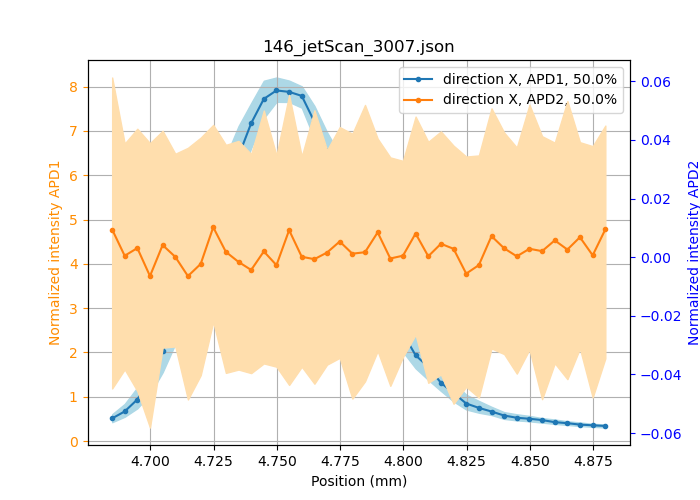

In [11]:
Int_APD1 = Signal_APD1[1:,0]
err_low_APD1 = Signal_APD1[1:,1]
err_high_APD1 = Signal_APD1[1:,2]

Int_APD2 = Signal_APD2[1:,0]
err_low_APD2 = Signal_APD2[1:,1]
err_high_APD2 = Signal_APD2[1:,2]


fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(1,1,1)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler


lns1 = ax1.plot(Position_mm[1:], Int_APD1, label='direction X, APD1, {}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Position_mm[1:], err_low_APD1, err_high_APD1, color='lightblue')

lns2 = ax2.plot(Position_mm[1:], Int_APD2, label='direction X, APD2, {}%'.format(quantile_band*100),marker='.')
ax2.fill_between(Position_mm[1:], err_low_APD2, err_high_APD2, color='navajowhite')


plt.title(fc.selected_filename)

ax1.set_xlabel("Position (mm)")

ax1.set_ylabel ("Normalized intensity APD1")
ax1.tick_params(axis='y', colors='darkorange')
ax1.yaxis.label.set_color('darkorange')

ax2.set_ylabel ("Normalized intensity APD2")
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')


leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
ax1.grid()

plt.show()